In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Device configuration (CPU or GPU if available)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')

# Load and preprocess data
df = pd.read_csv(r'C:\nano_optics_ml_data\processed\article_main_data.csv')  # Replace with your file path
# df = df.loc[(df['material'] != 'GaAs') & (df['material'] != 'CaF2')].reset_index(drop=True)
df = df.loc[(df['material'] != 'LSAT')].reset_index(drop=True)

# Calculate beta values using numpy
epsilon = df['eps1'].values + 1j * df['eps2'].values
beta = (epsilon - 1) / (epsilon + 1)
df['beta1'] = beta.real
df['beta2'] = beta.imag
materials = df['material'].values

# Prepare features and targets
# X = df[['beta1', 'beta2', 'Sn_fdm_real', 'Sn_fdm_imag']]
X = df[['beta1', 'beta2']]
y = df[['Sn_exp_real', 'Sn_exp_imag']]

# Convert to numpy arrays
X = X.values.astype(np.float32)
y = y.values.astype(np.float32)

# Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, materials_train, materials_test = train_test_split(
     X, y, materials, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Create Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define neural network architecture
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 8)
        self.layer2 = nn.Linear(8, 8)
        self.layer3 = nn.Linear(8, 8)
        self.output = nn.Linear(8, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.relu(self.layer1(x))
        out = self.relu(self.layer2(out))
        out = self.relu(self.layer3(out))
        return self.output(out)

# Initialize model
input_size = X_train.shape[1]
model = NeuralNet(input_size).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
 
# Training loop
num_epochs = 2500
epochs_dict = {}
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            
    epochs_dict[f'{epoch+1}'] = {'loss': loss.item(), 'test_loss': test_loss/len(test_loader)}
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss/len(test_loader):.4f}')

# Final evaluation
model.eval()
with torch.no_grad():
    total_loss = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        total_loss += criterion(outputs, labels).item()
        
print(f'Final Test Loss: {total_loss/len(test_loader):.4f}')

# Final evaluation: run predictions on the test set
model.eval()
with torch.no_grad():
    # Ensure X_test is on the proper device
    y_pred_tensor = model(X_test.to(device))
    # Bring predictions back to CPU and convert to numpy
    y_pred = y_pred_tensor.cpu().numpy()
    y_true = y_test.cpu().numpy()



AssertionError: Torch not compiled with CUDA enabled

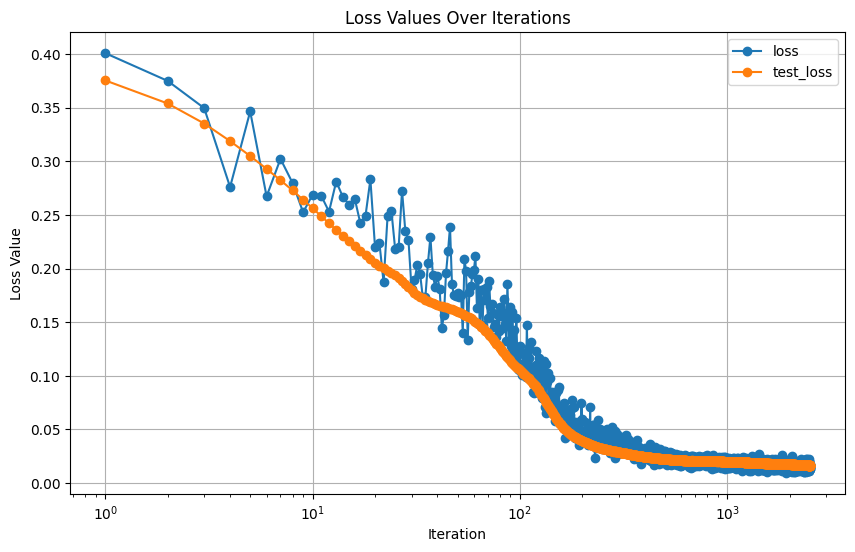

In [ ]:
import matplotlib.pyplot as plt
data = epochs_dict.copy()
# Convert dictionary keys to integers and sort them
x = sorted([int(k) for k in data.keys()])

# Extract the corresponding 'toss' and 'test_loss' values
toss_values = [data[str(k)]['loss'] for k in x]
test_loss_values = [data[str(k)]['test_loss'] for k in x]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, toss_values, marker='o', linestyle='-', label='loss')
plt.plot(x, test_loss_values, marker='o', linestyle='-', label='test_loss')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.title('Loss Values Over Iterations')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

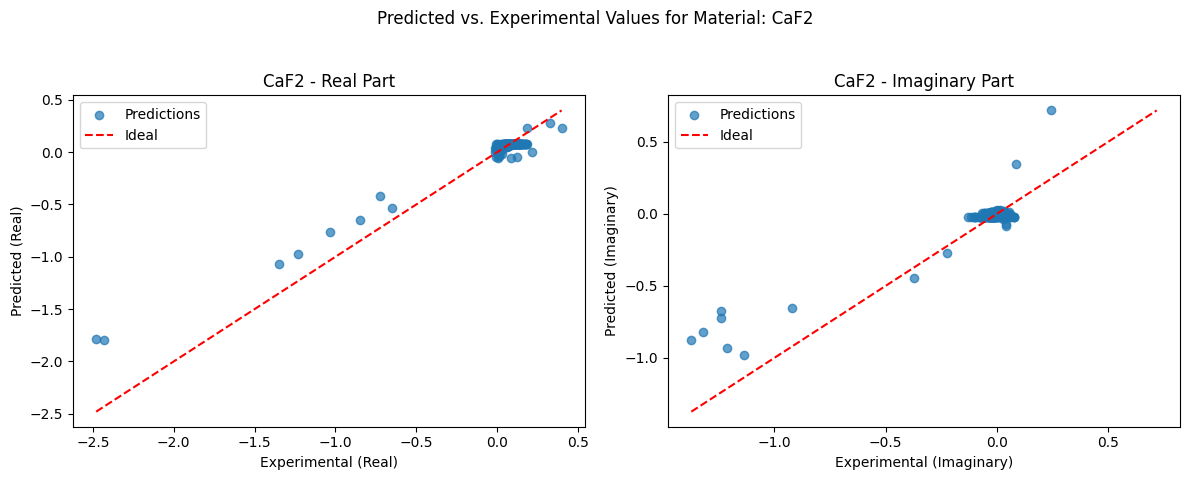

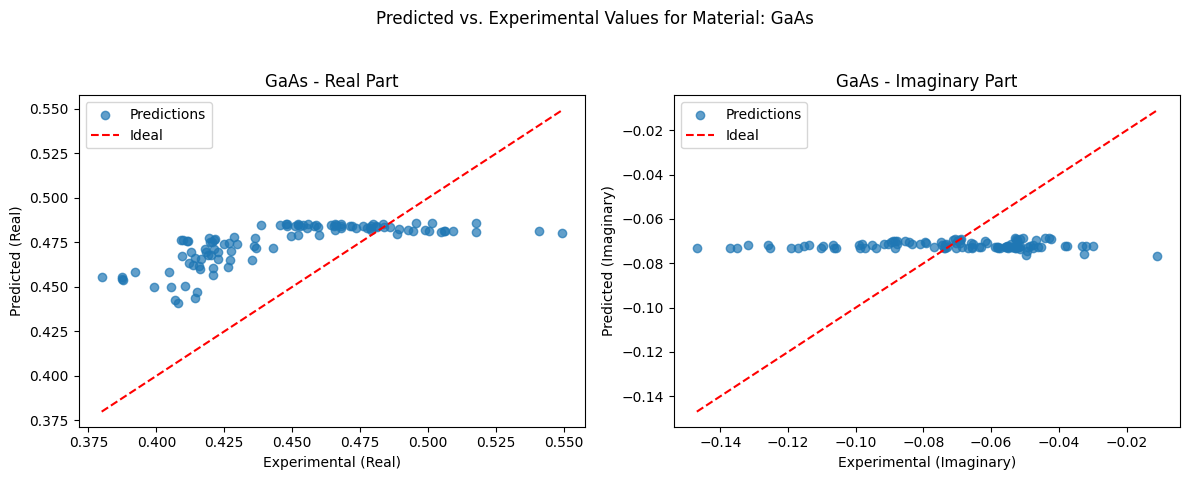

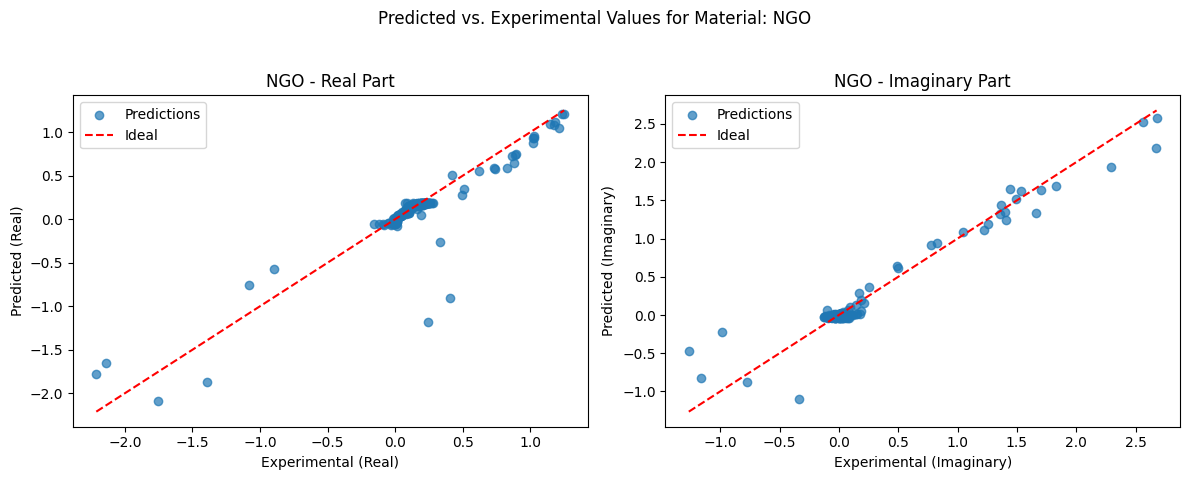

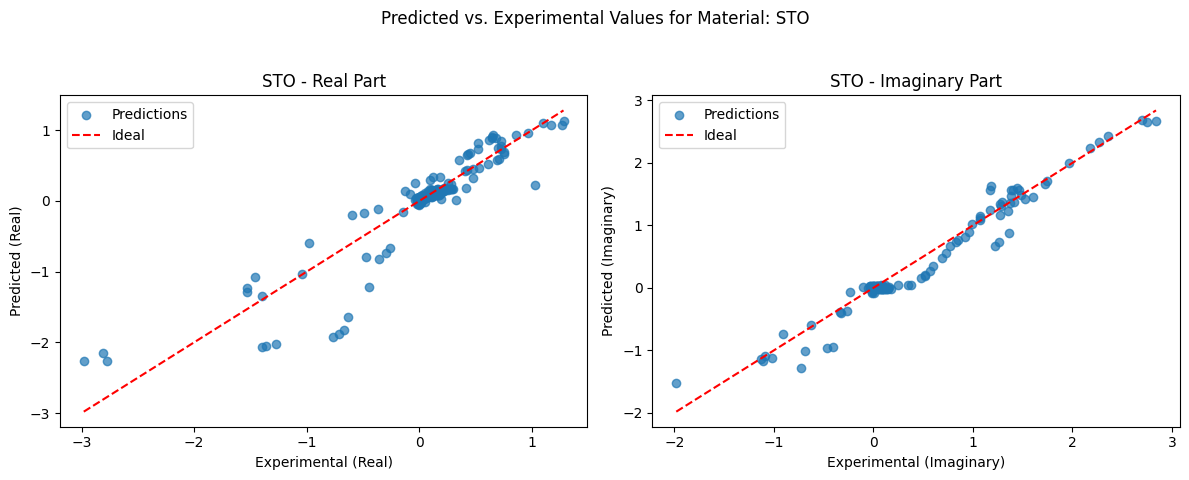

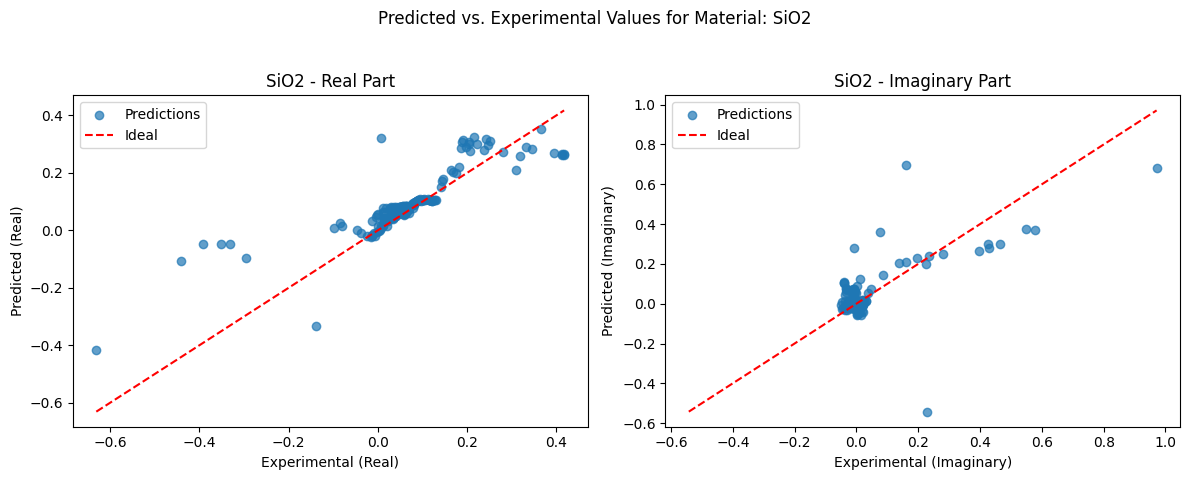

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert materials_test to a numpy array (if not already)
materials_test = np.array(materials_test)

# Get the unique materials present in the test set
unique_materials = np.unique(materials_test)

for mat in unique_materials:
    # Find indices for the current material
    idx = np.where(materials_test == mat)[0]
    
    # Create a new figure for this material
    plt.figure(figsize=(12, 5))
    
    # --- Plot for the Real Part ---
    plt.subplot(1, 2, 1)
    plt.scatter(y_true[idx, 0], y_pred[idx, 0], alpha=0.7, label='Predictions')
    # Plot y=x line for reference
    min_val = min(y_true[idx, 0].min(), y_pred[idx, 0].min())
    max_val = max(y_true[idx, 0].max(), y_pred[idx, 0].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
    plt.xlabel('Experimental (Real)')
    plt.ylabel('Predicted (Real)')
    plt.title(f'{mat} - Real Part')
    plt.legend()
    
    # --- Plot for the Imaginary Part ---
    plt.subplot(1, 2, 2)
    plt.scatter(y_true[idx, 1], y_pred[idx, 1], alpha=0.7, label='Predictions')
    # Plot y=x line for reference
    min_val = min(y_true[idx, 1].min(), y_pred[idx, 1].min())
    max_val = max(y_true[idx, 1].max(), y_pred[idx, 1].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
    plt.xlabel('Experimental (Imaginary)')
    plt.ylabel('Predicted (Imaginary)')
    plt.title(f'{mat} - Imaginary Part')
    plt.legend()
    
    plt.suptitle(f'Predicted vs. Experimental Values for Material: {mat}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


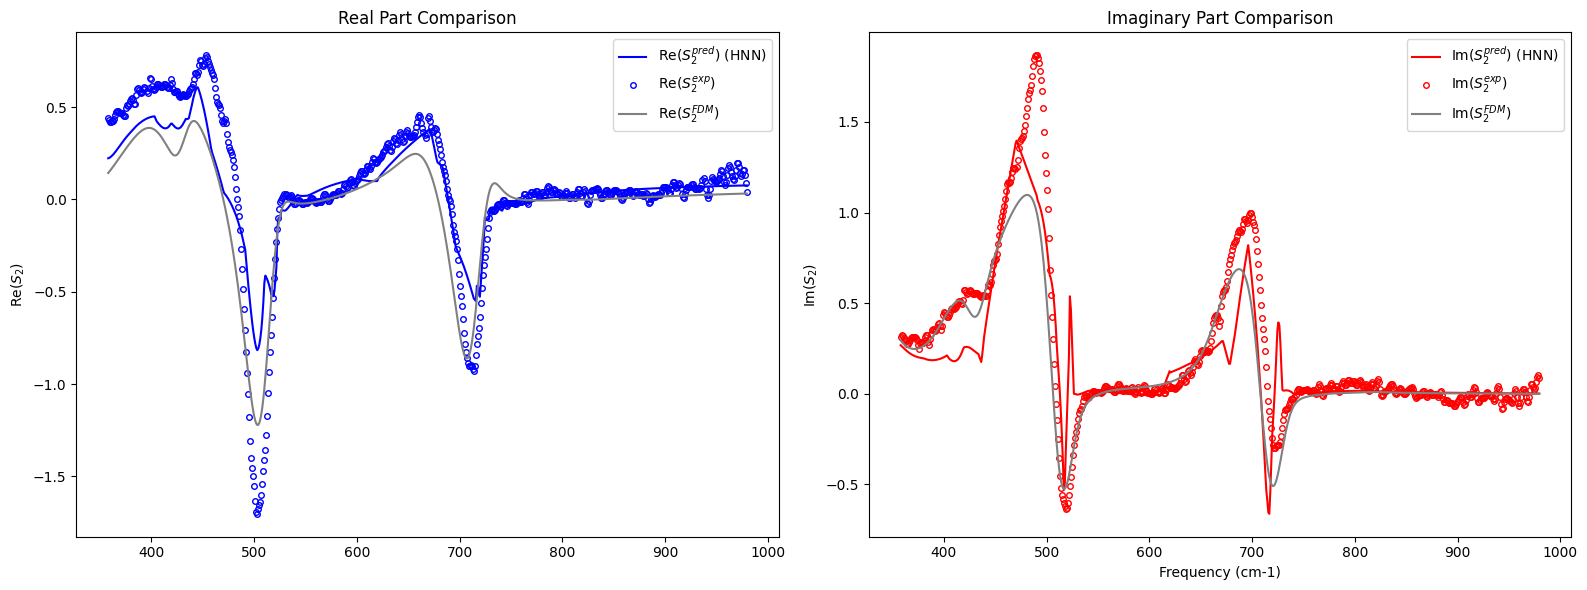

In [ ]:
df = pd.read_csv(r'C:\nano_optics_ml_data\processed\article_main_data.csv')  # Replace with your file path

epsilon = df['eps1'].values + 1j * df['eps2'].values
beta = (epsilon - 1) / (epsilon + 1)
df['beta1'] = beta.real
df['beta2'] = beta.imag
materials = df['material'].values

test_df = df.query("""material == 'LSAT'""")[['beta1', 'beta2', 'Sn_fdm_real', 'Sn_fdm_imag', 'f', 'Sn_exp_real','Sn_exp_imag']].copy()

x_values = (scaler.transform(test_df.drop(columns=['f', 'Sn_exp_real','Sn_exp_imag', 'Sn_fdm_real', 'Sn_fdm_imag']).values))

x_torch = torch.from_numpy(x_values).float()

output = model(x_torch.to(device))
output_df = pd.DataFrame(output.to('cpu').detach().numpy(), columns=['S2_pred_real', 'S2_pred_imag'])

output_df = pd.concat([test_df.reset_index(), output_df], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

axes[0].plot(output_df['f'], output_df['S2_pred_real'], 
             label=r'Re($S^{pred}_2$) (HNN)', linestyle='-', markersize=4, color='blue')
axes[0].plot(output_df['f'], output_df['Sn_exp_real'], 
             label=r'Re($S^{exp}_2$)', marker='o', linestyle='', markersize=4,markerfacecolor='none', markeredgecolor='blue',)
axes[0].plot(output_df['f'], output_df['Sn_fdm_real'], 
             label=r'Re($S^{FDM}_2$)', linestyle='-', markersize=4, color='gray')
axes[0].set_ylabel('Re($S_2$)')
axes[0].set_title('Real Part Comparison')
axes[0].legend()
# axes[0].grid(True)

axes[1].plot(output_df['f'], output_df['S2_pred_imag'], 
             label=r'Im($S^{pred}_2$) (HNN)', linestyle='-', markersize=4, color='red')
axes[1].plot(output_df['f'], output_df['Sn_exp_imag'], 
             label=r'Im($S^{exp}_2$)', marker='o', linestyle='', markersize=4, markerfacecolor='none', markeredgecolor='red',)
axes[1].plot(output_df['f'], output_df['Sn_fdm_imag'], 
             label=r'Im($S^{FDM}_2$)', linestyle='-', color='gray')
axes[1].set_ylabel('Im($S_2$)')
axes[1].set_title('Imaginary Part Comparison')
axes[1].legend()
# axes[1].grid(True)
axes[1].set_xlabel('Frequency (cm-1)')

plt.tight_layout()
plt.show()


In [ ]:
test_df.drop(columns=['f', 'Sn_exp_real','Sn_exp_imag'])

,beta1,beta2,Sn_fdm_real,Sn_fdm_imag
2393,0.944598,0.227414,0.143311,0.294227
2394,0.939421,0.222005,0.149960,0.287128
2395,0.934960,0.216246,0.156899,0.280681
2396,0.931222,0.210242,0.164072,0.274867
2397,0.928194,0.204095,0.171430,0.269667
...,...,...,...,...
3023,0.347318,0.019271,0.031509,-0.000371
3024,0.348409,0.019115,0.031668,-0.000395
3025,0.349491,0.018961,0.031826,-0.000419
3026,0.350564,0.018809,0.031983,-0.000442


In [ ]:
output_df

,index,beta1,beta2,Sn_fdm_real,Sn_fdm_imag,f,Sn_exp_real,Sn_exp_imag,S2_pred_real,S2_pred_imag
0,2393,0.944598,0.227414,0.143311,0.294227,357.883475,0.441747,0.311358,0.223112,0.267919
1,2394,0.939421,0.222005,0.149960,0.287128,358.863977,0.428524,0.322281,0.225376,0.262480
2,2395,0.934960,0.216246,0.156899,0.280681,359.844480,0.421856,0.316917,0.228735,0.257030
3,2396,0.931222,0.210242,0.164072,0.274867,360.824983,0.421139,0.309451,0.233057,0.251646
4,2397,0.928194,0.204095,0.171430,0.269667,361.805485,0.422330,0.301700,0.238207,0.246393
...,...,...,...,...,...,...,...,...,...,...
630,3023,0.347318,0.019271,0.031509,-0.000371,975.600157,0.160119,0.029526,0.075632,0.001395
631,3024,0.348409,0.019115,0.031668,-0.000395,976.580659,0.161704,0.065128,0.075751,0.001362
632,3025,0.349491,0.018961,0.031826,-0.000419,977.561162,0.132277,0.094629,0.075869,0.001328
633,3026,0.350564,0.018809,0.031983,-0.000442,978.541665,0.088832,0.102668,0.075987,0.001295
